<a href="https://colab.research.google.com/github/jku-win-dke/SemAI/blob/main/UE10_KGE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph Embeddings

This notebook is about your first steps with knowledge graph embedding models in PyKEEN. This notebook is loosely based on https://github.com/pykeen/pykeen/blob/master/notebooks/hello_world/hello_world.ipynb

You'll get to do the following:

1. train a model based on a small knowledge graph
2. evaluate how good it learned
3. turn it around and start making predictions.


# Preparations

## Install Packages

In [234]:
# Install packages if they're not already found
! pip install --upgrade pip
! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git
! python -c "import wordcloud" || pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [235]:
import os

import matplotlib.pyplot as plt
import torch

import pykeen
from pykeen.datasets import Countries
from pykeen.pipeline import pipeline
from pykeen import predict
from pykeen.triples import TriplesFactory

import requests
import numpy as np

import pandas as pd

pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Show environment variables

In [236]:
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,5.15.107+
Time,Mon Jun 19 08:55:12 2023
Python,3.10.12
PyKEEN,1.10.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.0.1+cu118
CUDA Available?,true


# The Knowledge Graph (Training and Testing Data)

- The training data and testing data are provided inline as String to facilitate manipulation.
- The triples are serialized as tab-separated values (TSV), with one line per triple and subject (head), predicate (relation), and object (tail) separated by tabs. Simple strings are used instead of URIs.
- For more intuitive experimentation, we make the split between Training Set and Test Set manually. That is, we provide Training Set and Test Set separately.

## Training Data

- For experimentation you can add and delete triples as you wish.
- You can add additional relations.

In [237]:
train_data_str = """
albania	language	albanian
albania	language	macedonian
albania	language	greek
albania	locatedin	southern_europe
albania	neighbor	greece
albania	neighbor	kosovo
albania	neighbor	macedonia
albania	neighbor	montenegro
andorra	language	catalan
andorra	locatedin	southern_europe
andorra	neighbor	france
andorra	neighbor	spain
austria	language	croatian
austria	language	german
austria	language	hungarian
austria	language	slovene
austria	locatedin	western_europe
austria	neighbor	czechia
austria	neighbor	germany
austria	neighbor	hungary
austria	neighbor	italy
austria	neighbor	liechtenstein
austria	neighbor	slovakia
austria	neighbor	switzerland
belarus	language	belarussian
belarus	language	russian
belarus	locatedin	eastern_europe
belarus	neighbor	latvia
belarus	neighbor	lithuania
belarus	neighbor	poland
belarus	neighbor	russia
belarus	neighbor	ukraine
belgium	neighbor	france
belgium	neighbor	germany
belgium	neighbor	luxembourg
belgium	neighbor	netherlands
bosnia_and_herzegovina	neighbor	croatia
bosnia_and_herzegovina	neighbor	montenegro
bosnia_and_herzegovina	neighbor	serbia
bulgaria	language	bulgarian
bulgaria	locatedin	eastern_europe
bulgaria	neighbor	greece
bulgaria	neighbor	macedonia
bulgaria	neighbor	romania
bulgaria	neighbor	serbia
bulgaria	neighbor	turkey
croatia	language	croatian
croatia	locatedin	southern_europe
croatia	neighbor	bosnia_and_herzegovina
croatia	neighbor	hungary
croatia	neighbor	montenegro
croatia	neighbor	serbia
croatia	neighbor	slovenia
cyprus	language	greek
cyprus	language	turkish
cyprus	locatedin	eastern_europe
cyprus	neighbor	united_kingdom
czechia	language	czech
czechia	locatedin	eastern_europe
czechia	neighbor	austria
czechia	neighbor	germany
czechia	neighbor	poland
czechia	neighbor	slovakia
denmark	language	danish
denmark	language	german
denmark	locatedin	northern_europe
denmark	neighbor	germany
estonia	language	estonian
estonia	locatedin	northern_europe
estonia	neighbor	latvia
estonia	neighbor	russia
finland	language	finnish
finland	language	swedish
finland	locatedin	northern_europe
finland	neighbor	norway
finland	neighbor	russia
finland	neighbor	sweden
france	language	french
france	locatedin	western_europe
france	neighbor	andorra
france	neighbor	belgium
france	neighbor	germany
france	neighbor	italy
france	neighbor	luxembourg
france	neighbor	monaco
france	neighbor	spain
france	neighbor	switzerland
germany	language	german
germany	locatedin	western_europe
germany	neighbor	austria
germany	neighbor	belgium
germany	neighbor	czechia
germany	neighbor	denmark
germany	neighbor	france
germany	neighbor	luxembourg
germany	neighbor	netherlands
germany	neighbor	poland
germany	neighbor	switzerland
gibraltar	language	english
gibraltar	language	spanish
gibraltar	locatedin	southern_europe
gibraltar	neighbor	spain
greece	language	greek
greece	locatedin	southern_europe
greece	neighbor	albania
greece	neighbor	bulgaria
greece	neighbor	macedonia
greece	neighbor	turkey
hungary	language	hungarian
hungary	locatedin	eastern_europe
hungary	neighbor	austria
hungary	neighbor	croatia
hungary	neighbor	romania
hungary	neighbor	serbia
hungary	neighbor	slovakia
hungary	neighbor	slovenia
hungary	neighbor	ukraine
iceland	language	icelandic
iceland	locatedin	northern_europe
ireland	locatedin	northern_europe
ireland	neighbor	united_kingdom
italy	language	italian
italy	locatedin	southern_europe
italy	neighbor	austria
italy	neighbor	france
italy	neighbor	san_marino
italy	neighbor	slovenia
italy	neighbor	switzerland
italy	neighbor	vatican_city
kosovo	language	albanian
kosovo	language	serbian
kosovo	locatedin	eastern_europe
kosovo	neighbor	albania
kosovo	neighbor	macedonia
kosovo	neighbor	montenegro
kosovo	neighbor	serbia
latvia	language	latvian
latvia	locatedin	northern_europe
latvia	neighbor	belarus
latvia	neighbor	estonia
latvia	neighbor	lithuania
latvia	neighbor	russia
liechtenstein	language	german
liechtenstein	locatedin	western_europe
liechtenstein	neighbor	austria
liechtenstein	neighbor	switzerland
lithuania	language	lithuanian
lithuania	locatedin	northern_europe
lithuania	neighbor	belarus
lithuania	neighbor	latvia
lithuania	neighbor	poland
lithuania	neighbor	russia
luxembourg	language	french
luxembourg	language	german
luxembourg	language	luxembourgish
luxembourg	locatedin	western_europe
luxembourg	neighbor	belgium
luxembourg	neighbor	france
luxembourg	neighbor	germany
malta	language	english
malta	language	maltese
malta	locatedin	southern_europe
macedonia	language	albanian
macedonia	language	macedonian
macedonia	locatedin	southern_europe
macedonia	neighbor	albania
macedonia	neighbor	bulgaria
macedonia	neighbor	greece
macedonia	neighbor	kosovo
macedonia	neighbor	serbia
moldova	language	romanian
moldova	locatedin	eastern_europe
moldova	neighbor	romania
moldova	neighbor	ukraine
monaco	language	french
monaco	language	italian
monaco	locatedin	western_europe
monaco	neighbor	france
montenegro	language	montenegrin
montenegro	language	albanian
montenegro	language	bosnian
montenegro	language	croatian
montenegro	language	serbian
montenegro	locatedin	southern_europe
montenegro	neighbor	albania
montenegro	neighbor	bosnia_and_herzegovina
montenegro	neighbor	croatia
montenegro	neighbor	kosovo
montenegro	neighbor	serbia
netherlands	language	dutch
netherlands	locatedin	western_europe
netherlands	neighbor	belgium
netherlands	neighbor	germany
norway	language	norwegian
norway	locatedin	northern_europe
norway	neighbor	finland
norway	neighbor	russia
norway	neighbor	sweden
poland	language	polish
poland	locatedin	eastern_europe
poland	neighbor	belarus
poland	neighbor	czechia
poland	neighbor	germany
poland	neighbor	lithuania
poland	neighbor	russia
poland	neighbor	slovakia
poland	neighbor	ukraine
portugal	language	portuguese
portugal	locatedin	southern_europe
portugal	neighbor	spain
romania	language	romanian
romania	locatedin	eastern_europe
romania	neighbor	bulgaria
romania	neighbor	hungary
romania	neighbor	moldova
romania	neighbor	serbia
romania	neighbor	ukraine
russia	language	russian
russia	locatedin	eastern_europe
russia	neighbor	belarus
russia	neighbor	estonia
russia	neighbor	finland
russia	neighbor	latvia
russia	neighbor	lithuania
russia	neighbor	norway
russia	neighbor	poland
russia	neighbor	ukraine
san_marino	language	italian
san_marino	locatedin	southern_europe
san_marino	neighbor	italy
serbia	language	serbian
serbia	locatedin	southern_europe
serbia	neighbor	bosnia_and_herzegovina
serbia	neighbor	bulgaria
serbia	neighbor	croatia
serbia	neighbor	hungary
serbia	neighbor	kosovo
serbia	neighbor	macedonia
serbia	neighbor	montenegro
serbia	neighbor	romania
slovakia	language	slovak
slovakia	locatedin	central_europe
slovakia	neighbor	austria
slovakia	neighbor	czechia
slovakia	neighbor	hungary
slovakia	neighbor	poland
slovakia	neighbor	ukraine
slovenia	language	hungarian
slovenia	language	italian
slovenia	language	slovene
slovenia	locatedin	southern_europe
slovenia	neighbor	austria
slovenia	neighbor	croatia
slovenia	neighbor	hungary
slovenia	neighbor	italy
spain	language	spanish
spain	language	catalan
spain	locatedin	southern_europe
spain	neighbor	andorra
spain	neighbor	france
spain	neighbor	gibraltar
spain	neighbor	morocco
spain	neighbor	portugal
sweden	language	swedish
sweden	language	finnish
sweden	locatedin	northern_europe
sweden	neighbor	finland
sweden	neighbor	norway
switzerland	neighbor	austria
switzerland	neighbor	france
switzerland	neighbor	germany
switzerland	neighbor	italy
switzerland	neighbor	liechtenstein
turkey	language	turkish
turkey	neighbor	bulgaria
turkey	neighbor	greece
ukraine	language	ukrainian
ukraine	language	russian
ukraine	locatedin	eastern_europe
ukraine	neighbor	belarus
ukraine	neighbor	hungary
ukraine	neighbor	moldova
ukraine	neighbor	poland
ukraine	neighbor	romania
ukraine	neighbor	russia
ukraine	neighbor	slovakia
united_kingdom	language	english
united_kingdom	locatedin	northern_europe
united_kingdom	neighbor	ireland
vatican_city	language	latin
vatican_city	language	italian
vatican_city	locatedin	southern_europe
vatican_city	neighbor	italy
""".strip()

## Testing Data

- The testing data does not affect the knowledge graph embedding. It is used to evaluate the quality of the embedding.
- Make sure that all entities and relations you use in the testing data are already present in the training data.

In [238]:
test_data_str = """
bosnia_and_herzegovina	language	bosnian
bosnia_and_herzegovina	language	croatian
bosnia_and_herzegovina	language	serbian
bosnia_and_herzegovina	locatedin	southern_europe
switzerland	language	german
switzerland	language	french
switzerland	language	italian
switzerland	locatedin	western_europe
belgium	language	dutch
belgium	language	french
belgium	language	german
belgium	locatedin	western_europe
""".strip()

## you may use these non-sensical test data to check how they affect the evaluation scores
test_data_str = """
bosnia_and_herzegovina	language	english
switzerland	language	croatian
switzerland	locatedin	southern_europe
belgium	language	russian
belgium	locatedin	belarus
""".strip()

## Triple Factories

- We convert the training and testing data to triple factories which are then used as input to the PyKeen pipeline.
- A triple factory maps each entity and each relation to a numeric ID. Internally, triples are represented as triples of numeric IDs.
- We make sure that the triples factory for the testing data uses the same entity and relation IDs as the triples factory for the training data.

In [239]:
train_data = np.array([triple.split("\t") for triple in train_data_str.split("\n")])
train_tf = TriplesFactory.from_labeled_triples(triples=train_data)

test_data = np.array([triple.split("\t") for triple in test_data_str.split("\n")])
test_tf = TriplesFactory.from_labeled_triples(
    triples=test_data,
    entity_to_id=train_tf.entity_to_id,
    relation_to_id=train_tf.relation_to_id)


## Check size and mappings of training and testing data

- We print the size of the training and testing sets and the mapping from labels to numeric IDs used by both triples factories.
- We print the triples from the testing data with IDs to quickly inspect correct mapping to IDs.

In [240]:
print("Size of Training Set: \n Entities: ", train_tf.num_entities, ", Relations: ", train_tf.num_relations, ", Triples: ", train_tf.num_triples)
print("Size of Testing Set: \n Entities: ", test_tf.num_entities, ", Relations: ", test_tf.num_relations, ", Triples: ", test_tf.num_triples)
print("Entity Labeling: \n", train_tf.entity_labeling)
print("Relation Labeling: \n", train_tf.relation_labeling)
print("Mapped Triples in Testing Set: \n",  test_tf.mapped_triples)

Size of Training Set: 
 Entities:  91 , Relations:  3 , Triples:  293
Size of Testing Set: 
 Entities:  91 , Relations:  3 , Triples:  5
Entity Labeling: 
 Labeling(label_to_id={'albania': 0, 'albanian': 1, 'andorra': 2, 'austria': 3, 'belarus': 4, 'belarussian': 5, 'belgium': 6, 'bosnia_and_herzegovina': 7, 'bosnian': 8, 'bulgaria': 9, 'bulgarian': 10, 'catalan': 11, 'central_europe': 12, 'croatia': 13, 'croatian': 14, 'cyprus': 15, 'czech': 16, 'czechia': 17, 'danish': 18, 'denmark': 19, 'dutch': 20, 'eastern_europe': 21, 'english': 22, 'estonia': 23, 'estonian': 24, 'finland': 25, 'finnish': 26, 'france': 27, 'french': 28, 'german': 29, 'germany': 30, 'gibraltar': 31, 'greece': 32, 'greek': 33, 'hungarian': 34, 'hungary': 35, 'iceland': 36, 'icelandic': 37, 'ireland': 38, 'italian': 39, 'italy': 40, 'kosovo': 41, 'latin': 42, 'latvia': 43, 'latvian': 44, 'liechtenstein': 45, 'lithuania': 46, 'lithuanian': 47, 'luxembourg': 48, 'luxembourgish': 49, 'macedonia': 50, 'macedonian': 51, 

## Word clouds of training set
For a quick overview of the training data we display a word cloud of entities and of relations, with size corresponding to frequency of appearance in triples.

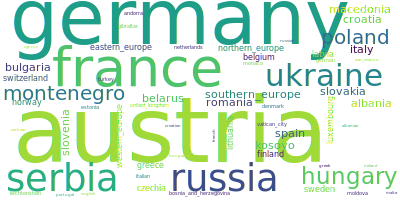

In [241]:
train_tf.entity_word_cloud()

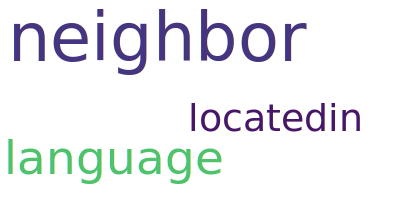

In [242]:
train_tf.relation_word_cloud()

# Train a Model

- We use PyKeen's `pipeline` to learn a knowledge graph embedding from the training data and to evaluate it using the testing data.

- We make use of of the *PairRE* knowledge graph embedding model (see https://arxiv.org/abs/2011.03798)

- You may want to try other KGE models such as TransE, TransR, RotatE, but it seems that PairRE works best for this kind of KG.

More tutorials on training your first model can be found [here](https://pykeen.readthedocs.io/en/latest/tutorial/first_steps.html).

In [243]:
result = pipeline(
    training=train_tf,
    testing=test_tf,
    model="PairRE",

    # Training configuration
    training_kwargs=dict(
        num_epochs=200,
        use_tqdm_batch=False,
    ),
    # Runtime configuration
    random_seed=1235,
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=5.


Evaluating on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


## Check improvement of embedding

Check that the loss is going down (and not oscillating) by plotting in the notebook.

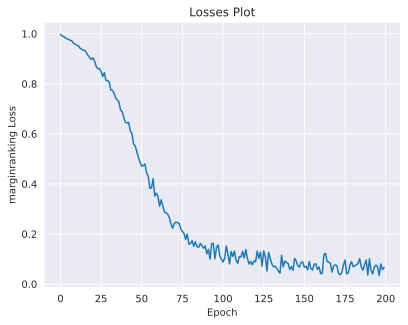

In [244]:
result.plot_losses()
plt.show()

## Quality metrics

- These metrics depend on the testing data.
- They measure how well the embedding can predict the testing data.

Look at the results. These are pretty tricky to interpret. We do not go into details here.

- adjusted mean rank is between [0, 2]. Closer to 0 is better!
- mean rank is a positive integer, with a bound based on the number of entities. Closer to 0 is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Closer to 1 is better!

In [245]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,adjusted_geometric_mean_rank_index,0.362415
1,tail,optimistic,adjusted_geometric_mean_rank_index,0.510181
2,both,optimistic,adjusted_geometric_mean_rank_index,0.419527
3,head,realistic,adjusted_geometric_mean_rank_index,0.362415
4,tail,realistic,adjusted_geometric_mean_rank_index,0.510180
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.101235
221,both,realistic,adjusted_hits_at_k,0.210660
222,head,pessimistic,adjusted_hits_at_k,0.320902
223,tail,pessimistic,adjusted_hits_at_k,0.101235


# Make predictions

It's very difficult to interpret KGEMs statistically, so it's best to sort order the predictions by their scores. All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

## Predict targets

- For a given head (i.e., subject) and relation (i.e., predicate), predict possible tails (i.e., objects).
- The higher (the less negative) the score, the more likely is the triple
- We add columns in_testing and in_training to check if the predicted triple is in the testing or training data.
- We only show the 10 most likely triples.

Example: What languages are spoken in Switzerland?


In [246]:
predict.predict_target(model=model, head="switzerland", relation="language", triples_factory=train_tf).add_membership_columns(testing=test_tf,training=train_tf).df.head(10)

,tail_id,score,tail_label,in_testing,in_training
29,29,-1.337264,german,False,False
39,39,-1.386838,italian,False,False
28,28,-1.447159,french,False,False
49,49,-1.671731,luxembourgish,False,False
76,76,-1.748431,slovene,False,False
42,42,-1.818914,latin,False,False
34,34,-1.838980,hungarian,False,False
11,11,-1.908198,catalan,False,False
83,83,-1.947686,switzerland,False,False
16,16,-1.948055,czech,False,False


## Filter predictions

Let's filter out the triples that are already included in the training set.

Example: Switzerland is located where?

In [247]:
# Automatically filter out non-novel predictions (e.g. in training or in testing is True)
predict.predict_target(model=model, head="switzerland", relation="locatedin", triples_factory=train_tf).add_membership_columns(testing=test_tf).filter_triples(train_tf).df.head(10)

,tail_id,score,tail_label,in_testing
90,90,-1.259134,western_europe,False
78,78,-1.783086,southern_europe,True
12,12,-1.908904,central_europe,False
21,21,-2.011058,eastern_europe,False
60,60,-2.099977,northern_europe,False
5,5,-2.106112,belarussian,False
87,87,-2.177985,ukrainian,False
64,64,-2.187941,polish,False
82,82,-2.199422,swedish,False
16,16,-2.215897,czech,False


## Predict subjects
- Given relation (predicate) and tail (object), predict heads (subjects).
- We filter out triples that are alreade in the training set.

Example: What is located in Western Europe?

In [248]:
predict.predict_target(model=model, tail="western_europe", relation="locatedin", triples_factory=train_tf).add_membership_columns(testing=test_tf).filter_triples(train_tf).df.head(10)

,head_id,score,head_label,in_testing
6,6,-1.243294,belgium,False
83,83,-1.259134,switzerland,False
17,17,-1.440710,czechia,False
19,19,-1.496341,denmark,False
63,63,-1.621742,poland,False
40,40,-1.633515,italy,False
75,75,-1.706578,slovakia,False
2,2,-1.715329,andorra,False
35,35,-1.773842,hungary,False
71,71,-1.811458,san_marino,False


## Predict all

- We may also predict all possible links (without specifying relations and head or tail relations).
- We filter out links that are in the training data.

In [249]:
prediction_df = predict.predict_all(model=model).process(factory=train_tf).add_membership_columns(testing=test_tf).filter_triples(train_tf).df
prediction_df.head(10)

scoring:   0%|          | 0.00/273 [00:00<?, ?batch/s]

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_testing
69,3,austria,2,neighbor,3,austria,-0.928332,False
93,35,hungary,2,neighbor,35,hungary,-0.978375,False
100,86,ukraine,2,neighbor,86,ukraine,-0.993361,False
110,30,germany,2,neighbor,30,germany,-1.019620,False
116,57,montenegro,2,neighbor,57,montenegro,-1.030883,False
133,72,serbia,2,neighbor,72,serbia,-1.057358,False
144,2,andorra,0,language,80,spanish,-1.072302,False
151,63,poland,2,neighbor,63,poland,-1.087659,False
152,17,czechia,2,neighbor,17,czechia,-1.090921,False
169,77,slovenia,2,neighbor,77,slovenia,-1.140516,False


## Custom filters

- The neighbor predictions are not interesting.
- Let's filter them out to focus on the predicted `language` and `locatedin` triples.

In [250]:
filtered = prediction_df[prediction_df['relation_label'] != 'neighbor']
filtered.head(20)

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_testing
144,2,andorra,0,language,80,spanish,-1.072302,False
192,69,russia,0,language,5,belarussian,-1.187988,False
232,6,belgium,1,locatedin,90,western_europe,-1.243294,False
241,32,greece,0,language,51,macedonian,-1.258073,False
242,83,switzerland,1,locatedin,90,western_europe,-1.259134,False
252,13,croatia,0,language,73,serbian,-1.273883,False
299,83,switzerland,0,language,29,german,-1.337264,False
301,50,macedonia,0,language,33,greek,-1.339343,False
303,65,portugal,0,language,80,spanish,-1.347698,False
310,46,lithuania,0,language,70,russian,-1.358016,False
